In [1]:
import numpy as np, uproot as ur, awkward as ak, pandas as pd
import matplotlib.pyplot as plt
import os, sys
import pickle
import scipy.stats as st
from collections import defaultdict
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from scipy.stats import poisson, norm
from scipy.spatial import ConvexHull

import mplhep as hep
plt.figure()
hep.style.use("CMS")
plt.close()

def gaus(x, amp, mean, sigma):
    return amp * np.exp( -(x - mean)**2 / (2*sigma**2) ) 

def phi_reconstruct(x, y, z):
    return np.degrees(np.arctan2(y, x))
    
def theta_reconstruct(x, y, z):
    return np.degrees(np.arccos(abs(z)/np.sqrt(x**2+y**2+z**2)))

def theta_x(x, y, z):
    return x/z

def theta_y(x, y, z):
    return y/z

def phi_reconstruct(x, y, z):
    return np.degrees(np.arctan2(y, x))

def theta_x_y(x, y, z):
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    
    tanx = theta_x(x_vec, y_vec, z_vec)
    tany = theta_y(x_vec, y_vec, z_vec)
    
    return tanx, tany

def vector_angle_reconstruct(x, y, z):
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    
    theta = theta_reconstruct(x_vec, y_vec, z_vec)
    phi = phi_reconstruct(x_vec, y_vec, z_vec)
    
    return theta, phi

def poisson_to_Z(N, lam):
    N = np.asarray(N, dtype=float)
    lam = np.asarray(lam, dtype=float)
    
    # Poisson CDF
    p = np.where(N >= lam,
                 poisson.cdf(N, lam),
                 1.0 - poisson.cdf(N, lam))
    
    # clip to avoid 0 or 1
    eps = 1e-16
    p = np.clip(p, eps, 1 - eps)
    
    # sign convention
    s = np.sign(lam - N)
    
    return s * norm.ppf(p)

def compute_kde_density(data, bandwidth, positions, phi_shape):
    values = np.vstack([np.array(data)[:,1], np.array(data)[:,0]])
    kernel = st.gaussian_kde(values)
    kernel.set_bandwidth(bw_method=bandwidth)
    density = np.reshape(kernel(positions).T, phi_shape)
    
    total_events = len(data)
    bin_area = (phi_grid[1]-phi_grid[0]) * (theta_grid[1]-theta_grid[0])
    return density * total_events * bin_area  # Convert to estimated counts

def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = None
    hep.style.use(hep.style.CMS)
plt.figure(figsize=(12, 10))

<Figure size 1200x1000 with 0 Axes>

In [2]:
arrays = {}
simfile = 'trigger_tiles.root'
arrays['muon']=ur.open(simfile+":events").arrays()

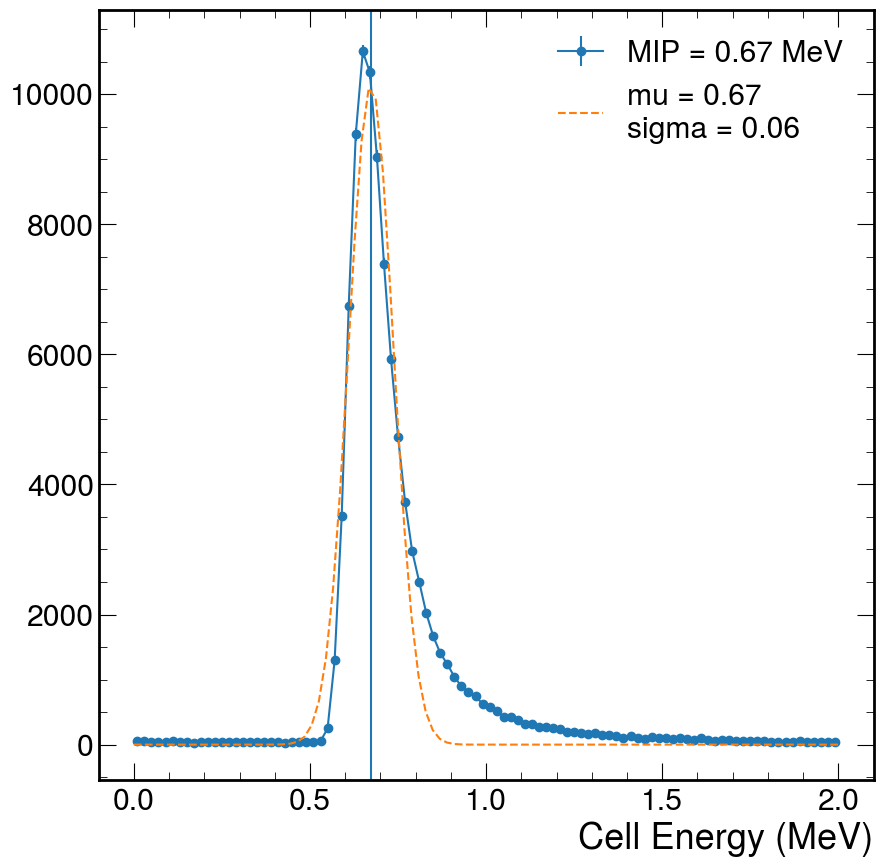

In [18]:
data_cell_cut = [True if len(cells)>=3 else False for cells in arrays['muon'][f"HcalFarForwardZDCHits.energy"]]
energy = ak.flatten(arrays['muon']["HcalFarForwardZDCHitsContributions.energy"][np.array(data_cell_cut)])
z = ak.flatten(arrays['muon']["HcalFarForwardZDCHits.position.z"][np.array(data_cell_cut)])
y,x=np.histogram(np.array(energy[z==99.375])*1000, bins=100, range=(0, 2))
bc=(x[1:]+x[:-1])/2
#MIP=list(bc[y==max(y)])[0] 
coeff, covar = curve_fit(gaus,np.asarray(bc[bc>0.5]),np.asarray(y[bc>0.5]))
MIP = coeff[1]
plt.errorbar(np.array(bc),np.array(y),yerr=np.sqrt(y),label=f'MIP = {MIP:.2f} MeV',fmt='-o')
plt.errorbar(np.linspace(0,2,100),gaus(np.linspace(0,2,100),*coeff),fmt='--',label=f'mu = {coeff[1]:.2f}' +'\n'+f'sigma = {abs(coeff[2]):.2f}')
plt.axvline(MIP)

plt.xlabel('Cell Energy (MeV)')
plt.legend()

In [19]:
status = arrays['muon']["MCParticles.generatorStatus"]
px = arrays['muon']["MCParticles.momentum.x"][status==1]
py = arrays['muon']["MCParticles.momentum.y"][status==1]
pz = arrays['muon']["MCParticles.momentum.z"][status==1]
mc_theta = theta_reconstruct(px,py,pz)

In [23]:
eng = []
data_cell_cut = [True if len(cells)>=3 else False for cells in arrays['muon'][f"HcalFarForwardZDCHits.energy"]]
energy = arrays['muon']["HcalFarForwardZDCHitsContributions.energy"][np.array(data_cell_cut)]
z = arrays['muon']["HcalFarForwardZDCHits.position.z"][np.array(data_cell_cut)]
the_ = mc_theta[np.array(data_cell_cut)]
thetas = []
lens = []
for i in range(len(z)):
    lens.append(len(z[i]))
    eng.append(energy[i][2])
    thetas.append(the_[i])

In [24]:
cut = ((0.1*MIP < 1000*np.array(eng)) & (1000*np.array(eng) < 5*MIP))

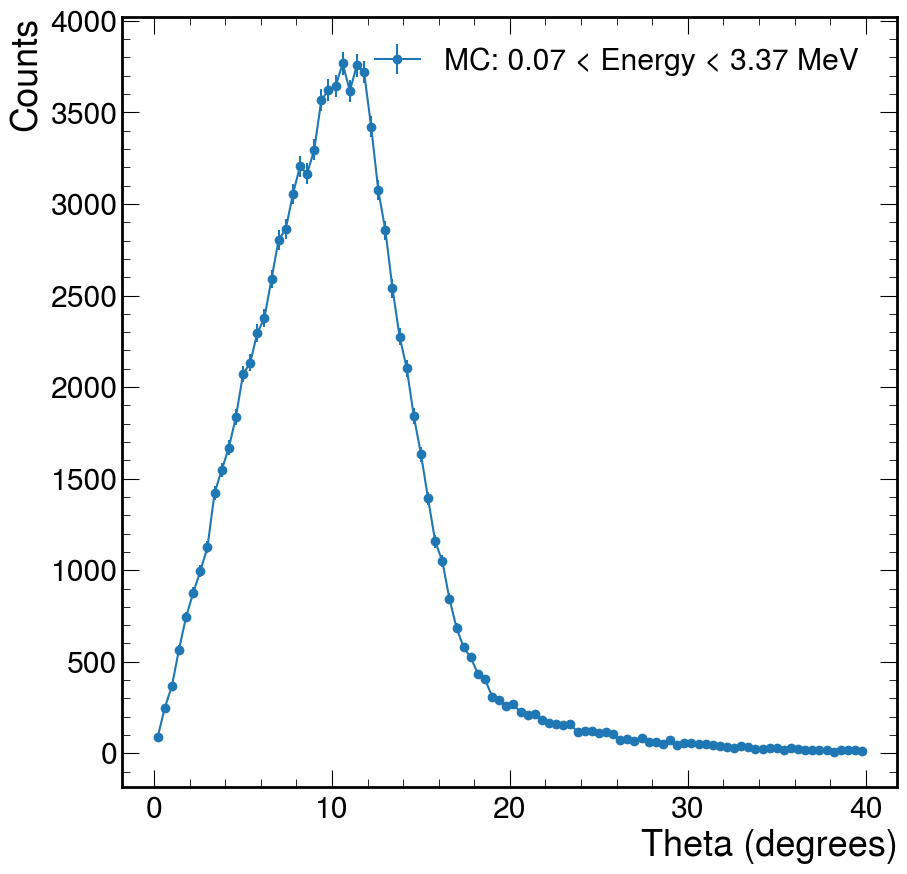

In [25]:
#plt.hist(np.array(thetas)[np.array(cut)],bins=100,range=(0,90))
y,x=np.histogram(np.array(ak.flatten(thetas))[np.array(cut)], bins=100, range=(0, 40))
bc=(x[1:]+x[:-1])/2
plt.errorbar(np.array(bc),np.array(y),yerr=np.sqrt(y),fmt='-o', label=f'MC: {0.1*MIP:.2f} < Energy < {5*MIP:.2f} MeV ')
plt.xlabel('Theta (degrees)')
plt.ylabel('Counts')
plt.legend()

In [46]:
with open(f'../caen/data/new_cable/2_trigger_tile/Run10_list.txt') as f:
    lines = f.read().split('  0  00')[1:]
df = {}
for i in range(64):
    df[str(f'{i:02}')] = []
dd = {}
for i in range(64):
    dd[str(f'{i:02}')] = []
for i in range(len(lines)):
    event = '  0  00' + lines[i]
    channels = [row.split() for row in event.split('\n')][:64]
    #if len(channels) != 9: continue
    channel = [row[1] for row in channels]
    LG = [int(row[2]) for row in channels]
    HG = [int(row[3]) for row in channels]
    for ch, gain in zip(channel,LG):
        dd[ch].append(gain)
    for ch, gain in zip(channel,HG):
        df[ch].append(gain)


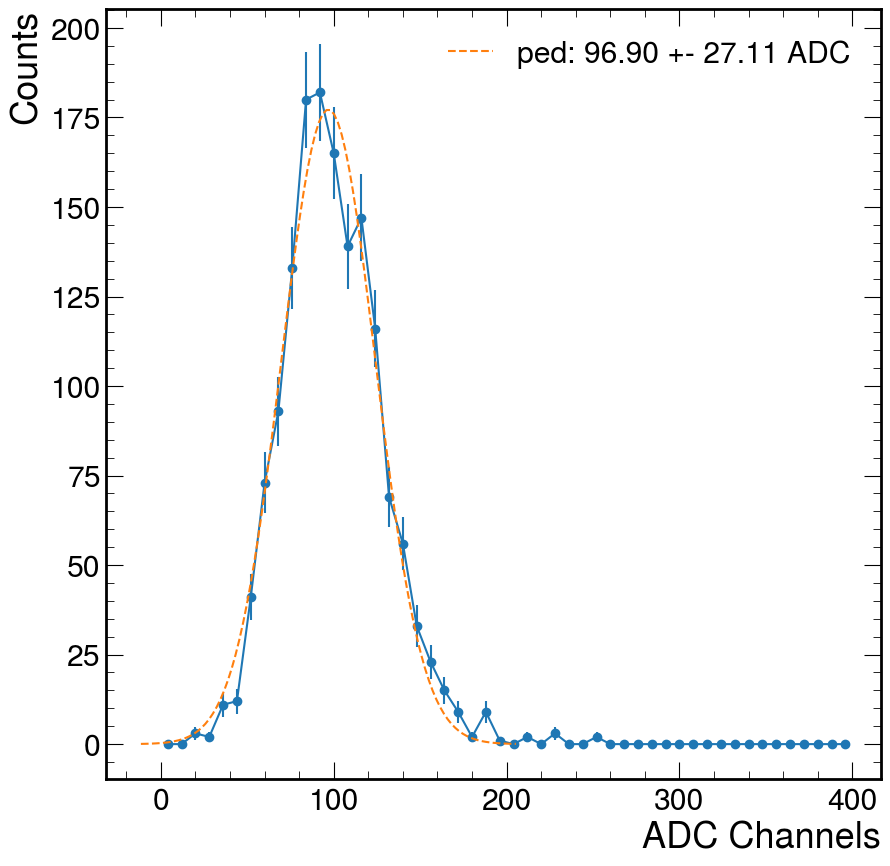

In [47]:
configure_plotting()
bins_small, edges = np.histogram(np.array(df['03'],dtype=int),bins=50,range=(0,400))
centers_small = edges[1:]/2+edges[:-1]/2
plt.errorbar(centers_small,bins_small,fmt='-o',yerr=np.sqrt(bins_small))

'''
peaks_lg = find_peaks_and_sigmas(centers, bins, distance=20, prominence=100, window=10)
for r in peaks_lg:
    plt.axvline(r[0], color='r', linestyle='--')
'''
covar, _ = curve_fit(gaus,centers_small,bins_small,p0=(1000,centers_small[np.argmax(bins_small)],200))
x = np.linspace(covar[1]-abs(covar[2])*4,covar[1]+abs(covar[2])*4,100)
plt.errorbar(x,gaus(x,*covar),fmt='--',label=f'ped: {covar[1]:.2f} +- {abs(covar[2]):.2f} ADC')
#plt.yscale('log')
plt.ylabel('Counts')
plt.xlabel('ADC Channels')
plt.legend()

In [48]:
with open(f'../caen/data/new_cable/2_trigger_tile/Run11_list.txt') as f:
    lines = f.read().split('  0  00')[1:]
df = {}
for i in range(64):
    df[str(f'{i:02}')] = []
dd = {}
for i in range(64):
    dd[str(f'{i:02}')] = []
for i in range(len(lines)):
    event = '  0  00' + lines[i]
    channels = [row.split() for row in event.split('\n')][:64]
    #if len(channels) != 9: continue
    channel = [row[1] for row in channels]
    LG = [int(row[2]) for row in channels]
    HG = [int(row[3]) for row in channels]
    for ch, gain in zip(channel,LG):
        dd[ch].append(gain)
    for ch, gain in zip(channel,HG):
        df[ch].append(gain)


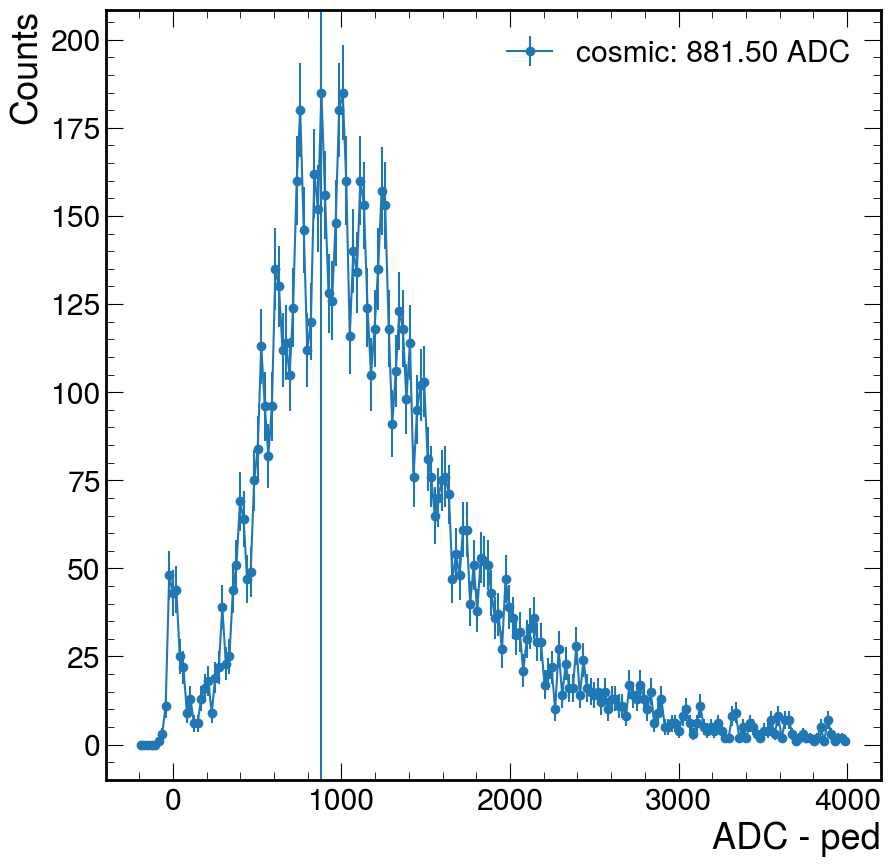

In [49]:
configure_plotting()
bins_small, edges = np.histogram(np.array(df['03'],dtype=int)-covar[1],bins=200,range=(-200,4000))
centers_small = edges[1:]/2+edges[:-1]/2
coeff = [max(bins_small[1:]),centers_small[np.argmax(bins_small[1:])+1]]
plt.errorbar(centers_small,bins_small,fmt='-o',yerr=np.sqrt(bins_small),label=f'cosmic: {coeff[1]:.2f} ADC')
#tile_2 = [centers_small,bins_small]
'''
peaks_lg = find_peaks_and_sigmas(centers, bins, distance=20, prominence=100, window=10)
for r in peaks_lg:
    plt.axvline(r[0], color='r', linestyle='--')
'''
#coeff, _ = curve_fit(gaus,centers_small[1:],bins_small[1:],p0=(1000,1000,50))
#x = np.linspace(0,coeff[1]+abs(coeff[2])*4,100)
#plt.errorbar(x,gaus(x,*coeff),fmt='--',label=f'cosmic: {coeff[1]:.2f} +- {abs(coeff[2]):.2f} ADC')
#plt.yscale('log')
plt.axvline(coeff[1])
plt.ylabel('Counts')
plt.xlabel('ADC - ped')
plt.legend()

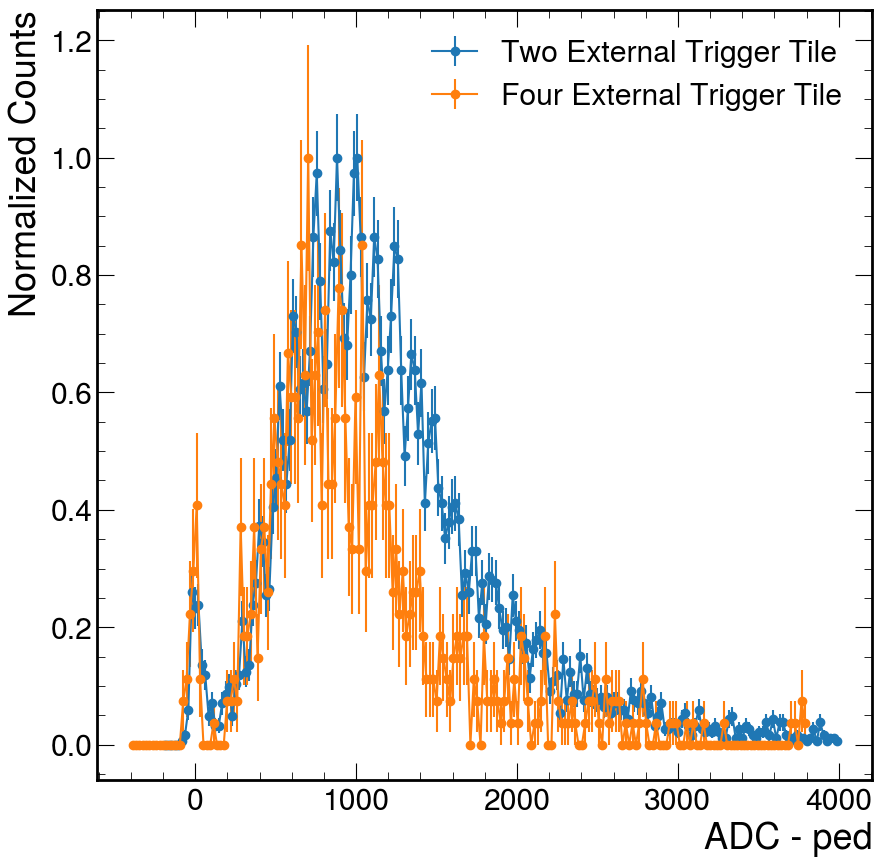

In [52]:
configure_plotting()
bins_small, edges = np.histogram(np.array(df['03'],dtype=int)-covar[1],bins=200,range=(-200,4000))
centers_small = edges[1:]/2+edges[:-1]/2
coeff = [max(bins_small[1:]),centers_small[np.argmax(bins_small[1:])+1]]
plt.errorbar(centers_small,bins_small/max(bins_small),fmt='-o',yerr=np.sqrt(bins_small)/max(bins_small),label=f'Two External Trigger Tile')
#tile_2 = [centers_small,bins_small]
plt.errorbar(tile_4[0]-200,tile_4[1]/max(tile_4[1]),fmt='-o',yerr=np.sqrt(tile_4[1])/max(tile_4[1]),label='Four External Trigger Tile')
'''
peaks_lg = find_peaks_and_sigmas(centers, bins, distance=20, prominence=100, window=10)
for r in peaks_lg:
    plt.axvline(r[0], color='r', linestyle='--')
'''
#coeff, _ = curve_fit(gaus,centers_small[1:],bins_small[1:],p0=(1000,1000,50))
#x = np.linspace(0,coeff[1]+abs(coeff[2])*4,100)
#plt.errorbar(x,gaus(x,*coeff),fmt='--',label=f'cosmic: {coeff[1]:.2f} +- {abs(coeff[2]):.2f} ADC')
#plt.yscale('log')
#plt.axvline(coeff[1])
plt.ylabel('Normalized Counts')
plt.xlabel('ADC - ped')
plt.legend()

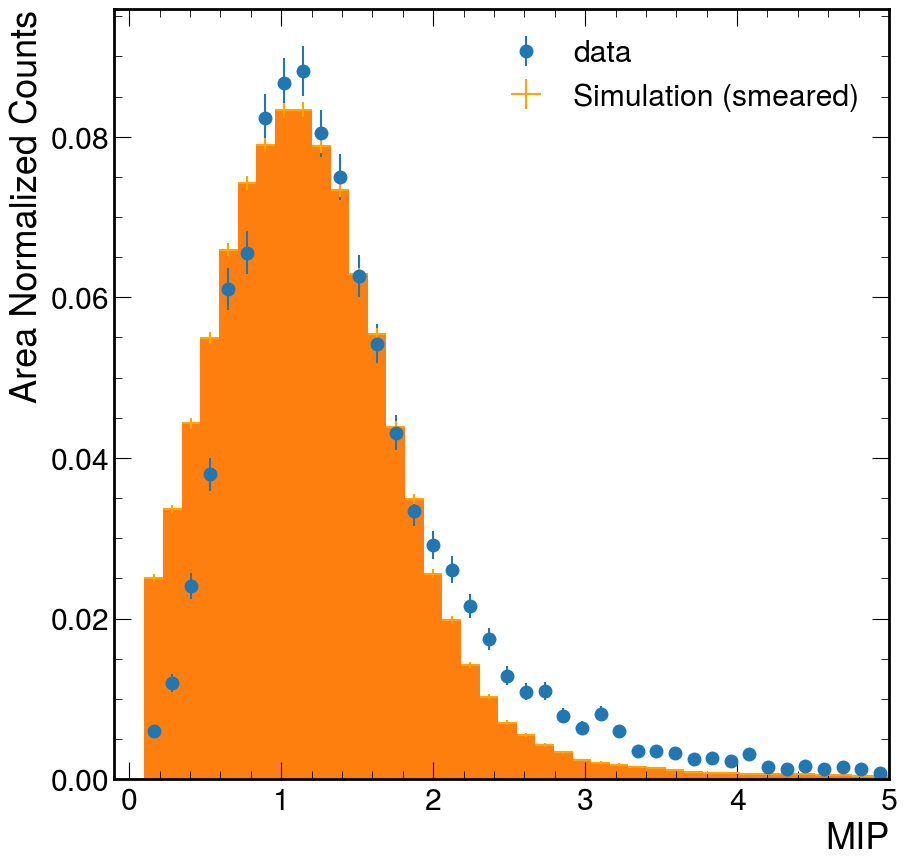

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
configure_plotting()
data = (np.array(energy[z==99.375])*1000)/MIP
bins_small, edges = np.histogram(data, bins=40, range=(0.1, 5))
centers_small = (edges[1:] + edges[:-1]) / 2
centers_mip = centers_small
area_data = np.sum(bins_small)
bins_norm = bins_small / area_data
bins_err_norm = np.sqrt(bins_small) / area_data

#plt.errorbar(centers_mip, bins_norm, fmt='-o',yerr=bins_err_norm, label='MC')


data = (np.array(df['03'], dtype=int) - covar[1])/coeff[1]
bins_small, edges = np.histogram(data, bins=40, range=(0.1, 5))
centers_small = (edges[1:] + edges[:-1]) / 2
centers_mip = centers_small
#data_mean = centers_small[np.argmax(bins_small)]
#data_std = np.std(np.clip(data,0.1,5))
area_data = np.sum(bins_small)
bins_norm = bins_small / area_data
bins_err_norm = np.sqrt(bins_small) / area_data
plt.errorbar(centers_mip, bins_norm, fmt='o',yerr=bins_err_norm, label='data',markersize=9)

coef, _ = curve_fit(gaus,centers_mip,bins_norm)
#plt.errorbar(np.linspace(0,2,100),gaus(np.linspace(0,2,100),*coef),fmt='--',label=f'mu = {coef[1]:.2f}' +'\n'+f'sigma = {abs(coef[2]):.2f}')
data_mean = coef[1]
data_std = coef[2]

sigma_bins = [0.56]
sigma_mean = []
sigma_std = []
# --- Parameters ---
#sigma_noise = 0.3  # Gaussian sigma in MIPs (tunable)
for sigma_noise in sigma_bins:
    area_mc = np.sum(y)  # sum counts in region
    y_norm = y / area_mc
    yerr_norm = np.sqrt(y) / area_mc
    E_smear = np.array(eng) * 1000/MIP + np.random.normal(0,sigma_noise,size=len(eng))
    #plt.errorbar(bc, y_norm, yerr=yerr_norm, label='MC', fmt='-o')
    y, x = np.histogram(E_smear, bins=40, range=(0.1, 5)) #MC Energy; MIP = 0.68 MeV
    bc = (x[1:] + x[:-1]) / 2
    y_smeared = y 
    
    coef, _ = curve_fit(gaus,bc,y)
    
    sigma_mean.append(coef[1])#bc[np.argmax(y)])
    
    sigma_std.append(abs(coef[2]))#np.std(np.clip(E_smear,0.1,5)))
    
    area_mc = np.sum(y_smeared)
    y_norm = y_smeared / area_mc
    yerr_norm = np.sqrt(y_smeared) / area_mc
    plt.errorbar(bc, y_norm, yerr=yerr_norm, xerr= 0.245/4, label=f'Simulation (smeared)', fmt='none',c='orange')
    plt.hist(
        bc, bins=x, weights=y_norm,
    )
# --- Data histogram (unchanged) ---
    #plt.errorbar(np.linspace(0,2,100),gaus(np.linspace(0,2,100),*coef)/ area_mc,fmt='--',label=f'noise_sig = {sigma_noise:.2f} MIP' +'\n'+f'sigma = {abs(coef[2]):.2f}')


# --- Plot settings ---
plt.xlim(-0.1, 5)
#plt.ylim(0, 0.15)
plt.xlabel('MIP')
plt.ylabel("Area Normalized Counts")
plt.legend()
#plt.show()
plt.savefig("Landau.png",format='png')

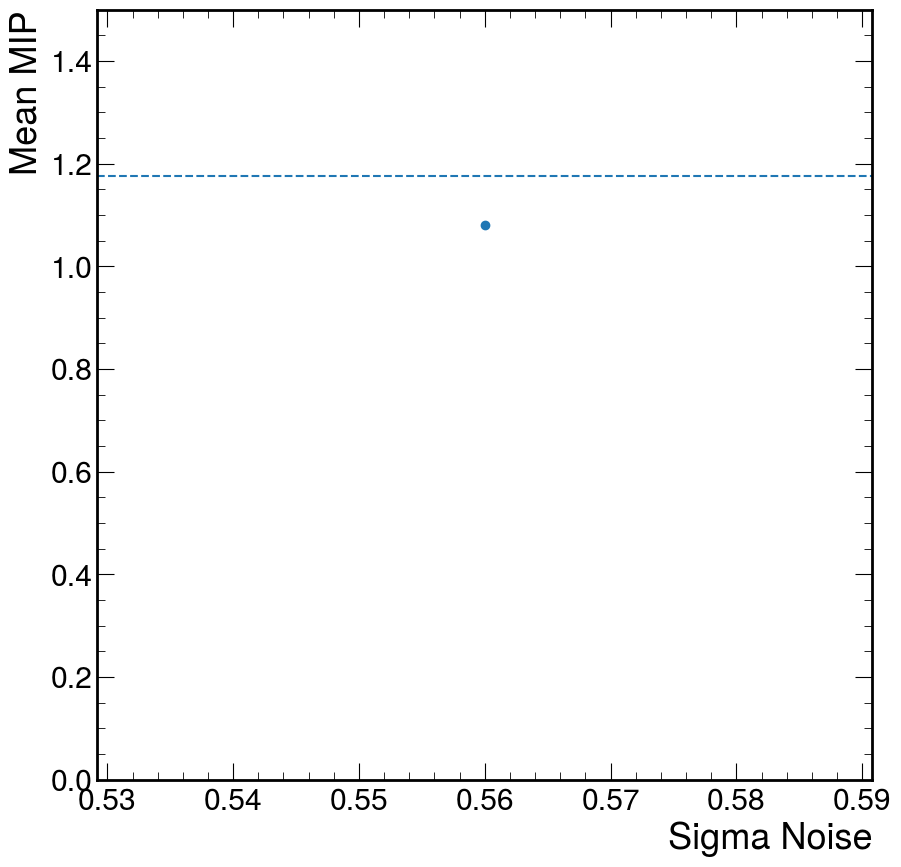

In [33]:
plt.errorbar(sigma_bins,sigma_mean,fmt='-o')
plt.xlabel('Sigma Noise')
plt.ylabel('Mean MIP')
plt.ylim(0,1.5)
plt.axhline(data_mean,linestyle='dashed',label='expected')

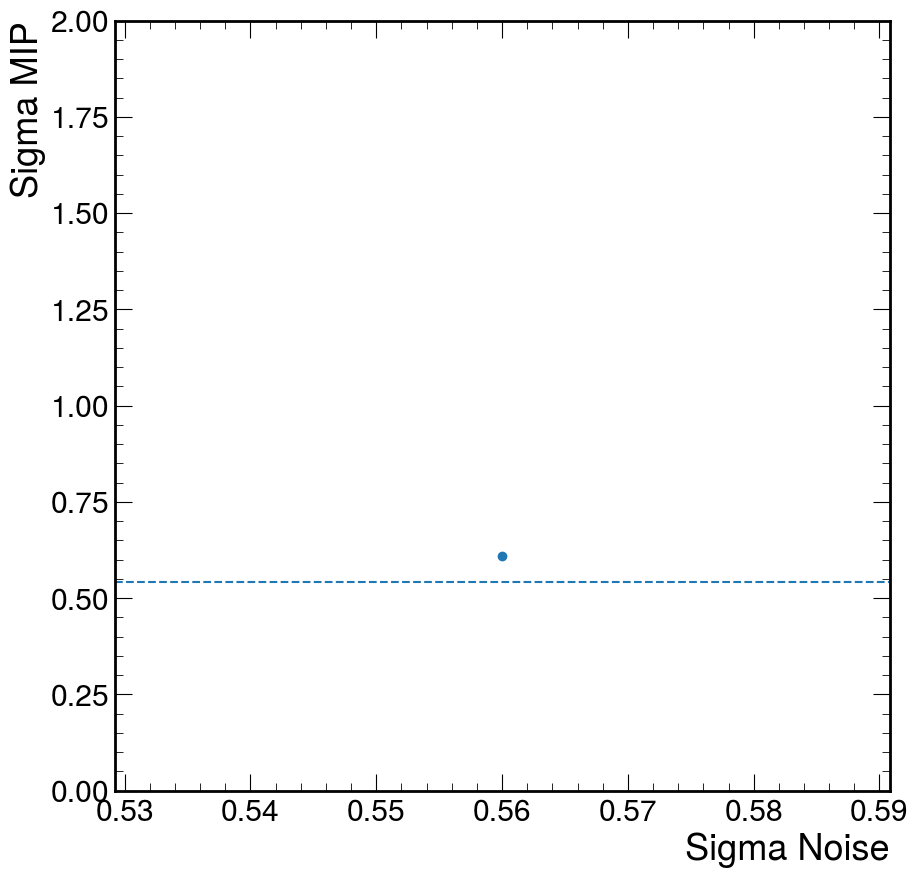

In [34]:
plt.errorbar(sigma_bins,sigma_std,fmt='-o')
plt.xlabel('Sigma Noise')
plt.ylabel('Sigma MIP')
plt.ylim(0,2)
plt.axhline(data_std,linestyle='dashed',label='expected')